what to do?
so when the models have different resolution we could do 2 things:
take highest resolution and for lower res ones take the value of nearest "pixel" for each one (this gives us high res results but lower resolution models will have high errors does not really work for them)
take lowest res and calculate the average of nearby "pixels"(maybe even by their overlap) for each large pixel this will work but only give us low res results

maybe do it individually for each model (so we can use that models res) to get a higher res lowest res estimate. (but that might be difficult and also makes it harder to compare models)

OKAY IDEA FOR NEXT, TAKE ElEVATION DATA AND GET THEN RESCALE IT TO ERA5/CMIP DATA BY TAKING AVERAGE (OR/AND ALSO TAKING STD AS ANOTHER DATA/PLOT TO SEE IF IT CORRELATES WITH VARIANCE OF HEIGHT)

In [1]:
import xarray as xr
import intake
from collections import defaultdict
import matplotlib.pyplot as plt
import xesmf
import numpy as np

wind : v -south-north

u: west-east

In [2]:
path_full = "lehre/msc-intro-computational-meteorology-exercises-w2025/ERA5/ERA5_monthly.1940-2025.t2m_wind10_pres.nc"
path_1deg = "lehre/msc-intro-computational-meteorology-exercises-w2025/ERA5/ERA5_monthly.1940-2025.t2m_wind10_pres.1deg.nc"
elevation_data_path = 'elevation_data/elevation_data.nc'
data = xr.open_dataset(path_full)
data_1deg = xr.open_dataset(path_1deg)
elevation_data = xr.open_dataset(elevation_data_path)

In [3]:
andes = [-32, -14, 360-78, 360-62]

In [4]:
def get_elevation_data(elevation_data, bounds=andes):
    lat_min, lat_max, lon_min, lon_max = bounds
    
    if (elevation_data.lon > 180).any():
        elevation_data = elevation_data.assign_coords(
            lon=((elevation_data.lon + 180) % 360) - 180
        ).sortby('lon')
    
    lon_min_180 = ((lon_min + 180) % 360) - 180
    lon_max_180 = ((lon_max + 180) % 360) - 180
    
    lat_coords = elevation_data.lat.values
    lat_ascending = lat_coords[0] < lat_coords[-1]
    
    lon_span = lon_max - lon_min
    if lon_span >= 359:
        elevation = elevation_data.sel(
            lat=slice(lat_min, lat_max) if lat_ascending else slice(lat_max, lat_min)
        )
    elif lon_min_180 > lon_max_180:
        # Wrapping around dateline
        elevation = xr.concat([
            elevation_data.sel(
                lon=slice(lon_min_180, 180),
                lat=slice(lat_min, lat_max) if lat_ascending else slice(lat_max, lat_min)
            ),
            elevation_data.sel(
                lon=slice(-180, lon_max_180),
                lat=slice(lat_min, lat_max) if lat_ascending else slice(lat_max, lat_min)
            )
        ], dim='lon')
    else:
        elevation = elevation_data.sel(
            lon=slice(lon_min_180, lon_max_180),
            lat=slice(lat_min, lat_max) if lat_ascending else slice(lat_max, lat_min)
        )

    return elevation

In [5]:
def lat_lon_sel(data,lat_bnds,lon_bnds,attributes):
    lat_vals = data[attributes[0]][attributes[1]].values
    long_vals = data[attributes[0]][attributes[2]].values

    lat_vals = lat_vals[lat_vals>lat_bnds[0]]
    lat_vals = lat_vals[lat_vals<lat_bnds[1]]

    long_vals = long_vals[long_vals>lon_bnds[0]]
    long_vals = long_vals[long_vals<lon_bnds[1]]
    return lat_vals,long_vals


In [6]:
andes = [-32, -14, 360-78, 360-62]

lat_boundary = [-90,90]#[-32,-14]
long_boundary = [0,360]#[360-78,360-62]
""" 
"""
lat_boundary = [-34,-12]
long_boundary = [360-80,360-60]
""" #"""
attributes = ["t2m","latitude","longitude"]
#lat_vals,long_vals = lat_lon_sel(data_wind,lat_boundary,long_boundary,attributes)

In [7]:
#data_wind["v10"].sel({"latitude":lat_vals,"longitude":long_vals}).mean("valid_time").plot()

CIMP6 data

In [8]:
cat = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
query = dict(
    variable_id=['tas'],
    table_id='Amon',
    experiment_id=['historical'],
    grid_label='gn',
    member_id='r1i1p1f1'
)

cat_subset = cat.search(require_all_on=["source_id"], **query)
dsets = cat_subset.to_dataset_dict(
    zarr_kwargs={'consolidated': True},
    storage_options={'token': 'anon'}
)
list(dsets)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['CMIP.SNU.SAM0-UNICON.historical.Amon.gn',
 'CMIP.CMCC.CMCC-CM2-SR5.historical.Amon.gn',
 'CMIP.NCC.NorCPM1.historical.Amon.gn',
 'CMIP.MIROC.MIROC6.historical.Amon.gn',
 'CMIP.NASA-GISS.GISS-E2-2-H.historical.Amon.gn',
 'CMIP.BCC.BCC-ESM1.historical.Amon.gn',
 'CMIP.FIO-QLNM.FIO-ESM-2-0.historical.Amon.gn',
 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.Amon.gn',
 'CMIP.CSIRO.ACCESS-ESM1-5.historical.Amon.gn',
 'CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn',
 'CMIP.AS-RCEC.TaiESM1.historical.Amon.gn',
 'CMIP.CAS.CAS-ESM2-0.historical.Amon.gn',
 'CMIP.NCAR.CESM2-WACCM.historical.Amon.gn',
 'CMIP.NCAR.CESM2-WACCM-FV2.historical.Amon.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn',
 'CMIP.NUIST.NESM3.historical.Amon.gn',
 'CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Amon.gn',
 'CMIP.NCAR.CESM2-FV2.historical.Amon.gn',
 'CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn',
 'CMIP.NCC.NorESM2-MM.historical.Amon.gn',
 'CMIP.UA.MCM-UA-1-0.historical.Amon.gn',
 'CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.Amon.gn',
 'C

In [9]:
dsiter = iter(dsets)

n = 2
current_model = next(dsiter)
#current_model = next(dsiter)
curr_ds = dsets[current_model]
curr_ds = curr_ds.sortby("time")

atts_cmip = ["tas","lat","lon"]
#lat_vals_cmip,lon_vals_cmip = lat_lon_sel(curr_ds,lat_boundary,long_boundary,atts_cmip)

In [10]:
current_model = next(dsiter)
#current_model = next(dsiter)
curr_ds = dsets[current_model]
curr_ds = curr_ds.sortby("time")

In [11]:
start_date = "1940-01-01"
end_date   = "2026-12-31"

andes = [-32, -14, 360-78+0.5, 360-62+0.5]
boundary = andes
cutoff = 2.1
pre_cut_boundary = [boundary[0]-cutoff,boundary[1]+cutoff,boundary[2]-cutoff,boundary[3]+cutoff]
Era5_1deg_red = data_1deg["t2m"].sel({"lat":slice(pre_cut_boundary[0],pre_cut_boundary[1]),"lon":slice(pre_cut_boundary[2],pre_cut_boundary[3])}).rename({"valid_time":"time"}).sel({"time":slice(start_date,end_date)})
Cmip_data_red = curr_ds["tas"].sel({"lat":slice(pre_cut_boundary[0],pre_cut_boundary[1]),"lon":slice(pre_cut_boundary[2],pre_cut_boundary[3])}).sel({"time":slice(start_date,end_date)})

Era5_1deg_red["time"] = Era5_1deg_red.time.astype("datetime64[ns]")

regrid_cmip_to_era5 = xesmf.Regridder(Cmip_data_red, Era5_1deg_red, method='bilinear', periodic=True)
tas = regrid_cmip_to_era5(Cmip_data_red)


I AM Currently taking different dates in the Era 5 and the CMIP data(ERA5 always has 1st of month while CMIP has middle day of month. in the mean this should not matter though:/)

In [12]:
tas["time"]

<xarray.DataArray 'time' (time: 900)> Size: 7kB
array([cftime.DatetimeNoLeap(1940, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1940, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1940, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2014, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    height   float64 8B ...
  * time     (time) object 7kB 1940-01-16 12:00:00 ... 2014-12-16 12:00:00

In [13]:
current_model = next(dsiter)
#current_model = next(dsiter)
curr_ds = dsets[current_model]
curr_ds = curr_ds.sortby("time")


start_date = "1940-01-01"
end_date   = "2026-12-31"

andes = [-32, -14, 360-78+0.5, 360-62+0.5]
boundary = andes
cutoff = 2.1

def idkwhattocallthis(curr_ds,boundary = andes,cutoff = cutoff):
    pre_cut_boundary = [boundary[0]-cutoff,boundary[1]+cutoff,boundary[2]-cutoff,boundary[3]+cutoff]

    Era5_1deg_red = data_1deg["t2m"].sel({"lat":slice(pre_cut_boundary[0],pre_cut_boundary[1]),"lon":slice(pre_cut_boundary[2],pre_cut_boundary[3])}).rename({"valid_time":"time"}).sel({"time":slice(start_date,end_date)})
    Cmip_data_red = curr_ds["tas"].sel({"lat":slice(pre_cut_boundary[0],pre_cut_boundary[1]),"lon":slice(pre_cut_boundary[2],pre_cut_boundary[3])}).sel({"time":slice(start_date,end_date)})

    Era5_1deg_red_mean = Era5_1deg_red.mean("time")
    Cmip_data_red_mean = Cmip_data_red.mean("time")

    regrid_cmip_to_era5 = xesmf.Regridder(Cmip_data_red, Era5_1deg_red, method='bilinear', periodic=True)
    #regrid_cmip_to_era5_mean = xesmf.Regridder(Cmip_data_red_mean, Era5_1deg_red_mean, method='bilinear', periodic=True)
    #regrid_era5_to_cmip =  xesmf.Regridder(Era5_1deg_red , Cmip_data_red, method='bilinear', periodic=True)
    #Cmip_data_red = Cmip_data_red.sel({"time":slice(start_date,end_date)})
    tas = regrid_cmip_to_era5(Cmip_data_red)
    #E5_regrid = regrid_era5_to_cmip(Era5_1deg_red)
    tas_mean = regrid_cmip_to_era5(Cmip_data_red_mean)

    b = Era5_1deg_red.resample(time="1ME").nearest()
    a = tas.resample(time="1ME").nearest()
    a["time"] = a.time.astype("datetime64[ns]")

    cutoff = 2.1
    lat_boundary_adj = [boundary[0],boundary[1]]#[-32,-14]
    long_boundary_adj =  [boundary[2],boundary[3]]#[360-78,360-62]
    atts1deg = ["t2m","lat","lon"]

    #lat_vals_1deg,long_vals_1deg = lat_lon_sel(data_1deg,lat_boundary_adj,long_boundary_adj,atts1deg)

    a = a.sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])})
    b = b.sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])})

    mean_abs_diff = abs(a-b).mean("time")
    temp_variance = (abs(a-a.mean("time")+b.mean("time"))-b).mean("time")
    plt.figure()
    mean_abs_diff.plot()
    plt.title("absolute Temperature difference Era5-model, model="+str(a.member_id.values[0]))
    plt.figure()
    ((a-b)).mean("time").plot()
    plt.title("Temperature difference")
    plt.figure()
    temp_variance.plot()#plot showing how much the variance of Temp over time differs
    plt.title("difference in Temperature variation")


    elevation_andes = get_elevation_data(elevation_data,bounds=andes)
    x =elevation_andes.coarsen({"lat":60,"lon":60},coord_func="mean")
    elevation_mean = x.mean()
    elevation_std = x.std()

    plt.figure()
    plt.scatter(elevation_mean["z"].values,(a-b).mean("time").values)
    plt.ylabel("differnece in Temperature Model-Era5")
    plt.xlabel("mean altitude of gridcell")
    plt.figure()
    plt.scatter(elevation_std["z"].values,(a-b).mean("time").values)
    plt.ylabel("differnece in Temperature Model-Era5")
    plt.xlabel("standard deviation of altutude of gridcell")
    #same but with absolute values before mean
    plt.figure()
    plt.scatter(elevation_mean["z"].values,mean_abs_diff.values)
    plt.ylabel("mean absolute differnece in Temperature Model-Era5")
    plt.xlabel("mean altitude of gridcell")
    plt.figure()
    plt.scatter(elevation_std["z"].values,mean_abs_diff.values)
    plt.ylabel("mean absolute differnece in Temperature Model-Era5")
    plt.xlabel("standard deviation of altutude of gridcell")

    plt.figure()
    plt.ylabel("Temperature")
    plt.xlabel("Mean altutude of gridcell")
    plt.scatter(elevation_mean["z"].values.flatten(),a.mean("time").values.flatten(),label="Model")

    plt.scatter(elevation_mean["z"].values.flatten(),b.mean("time").values.flatten(),label="Era5")
    plt.legend()

    plt.figure()
    plt.title("diffrence in Temperature variance depending on altitude")
    plt.scatter(elevation_mean["z"].values.flatten(),temp_variance.values.flatten())



/tmp/ipykernel_77/3556375994.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


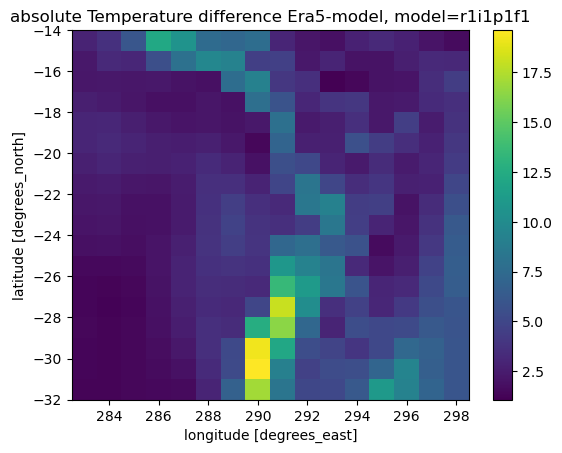

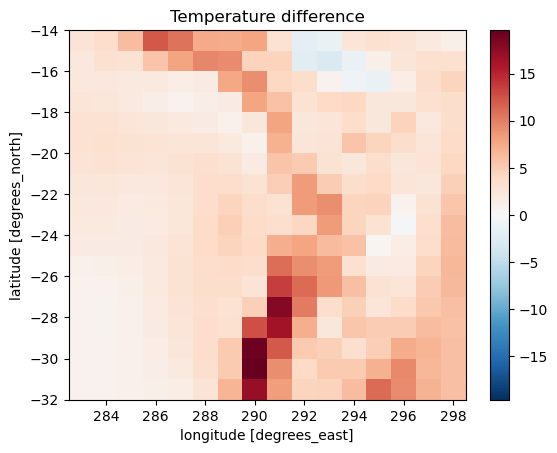

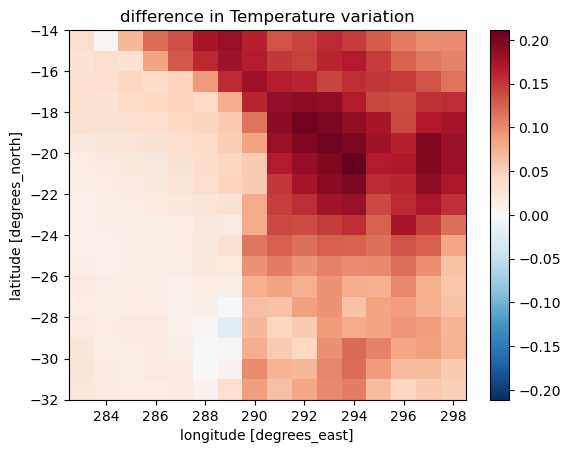

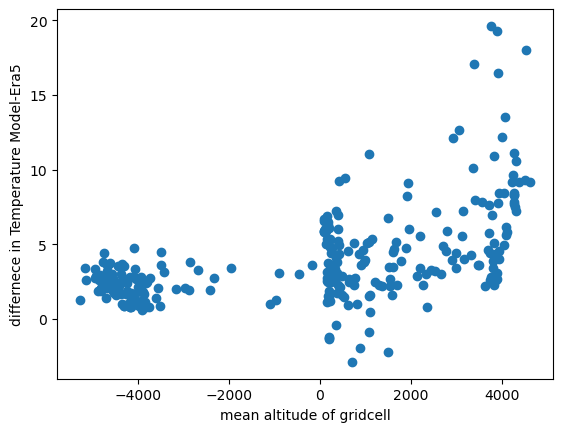

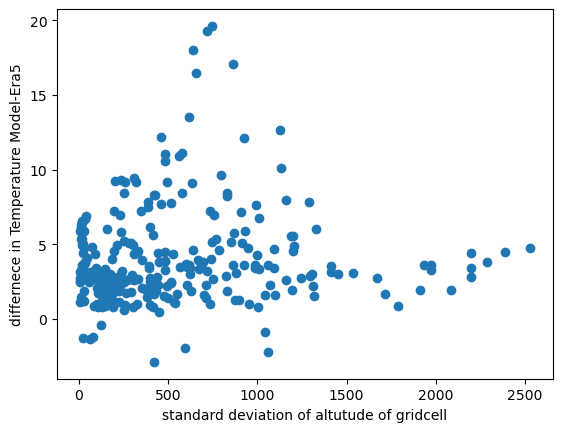

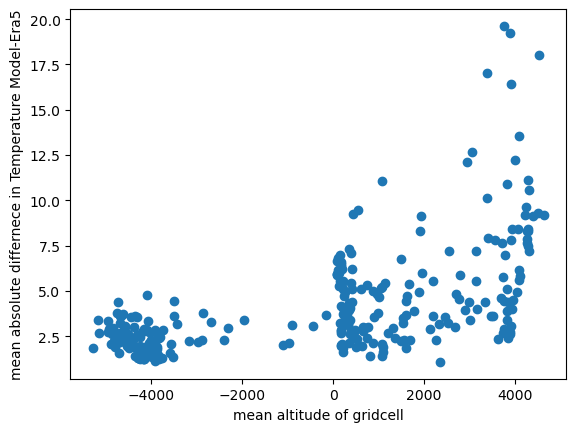

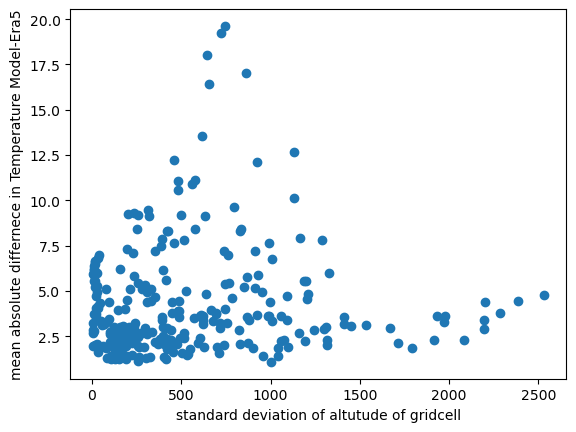

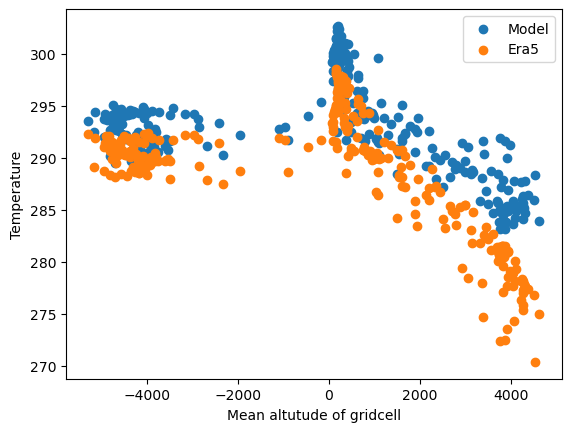

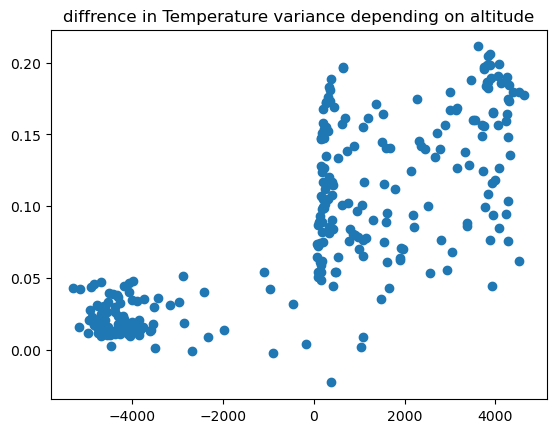

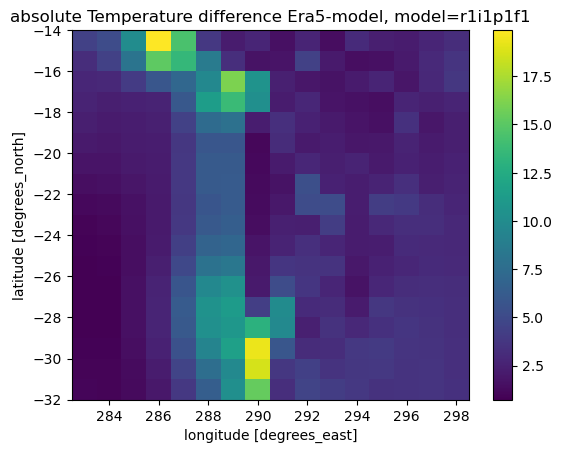

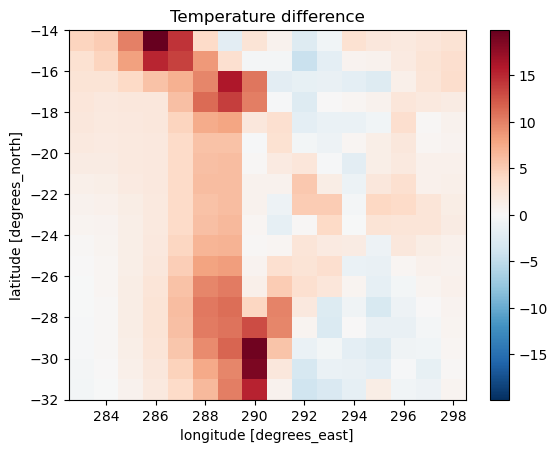

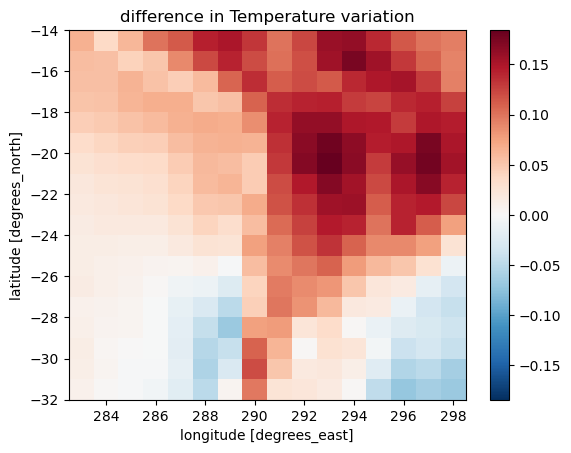

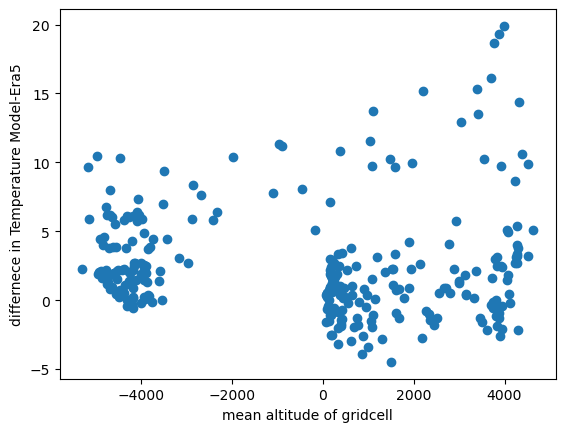

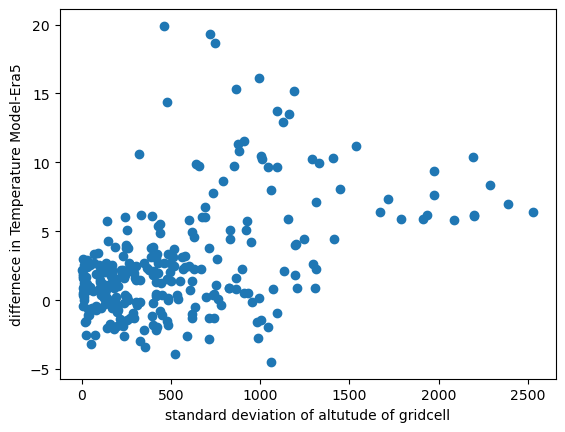

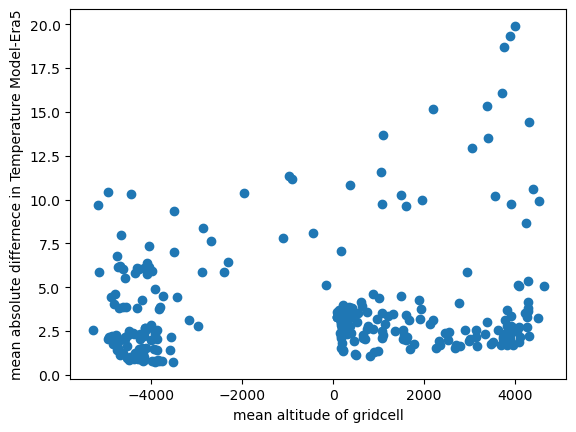

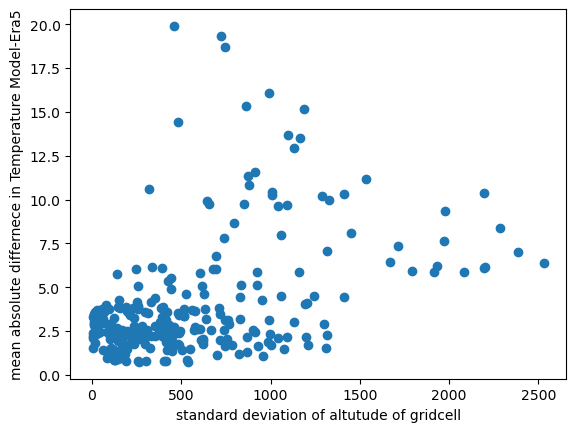

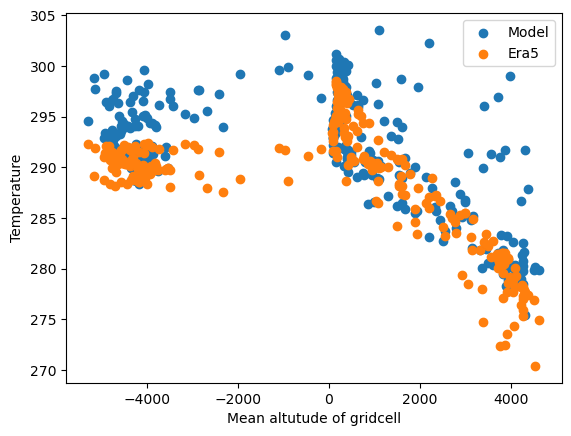

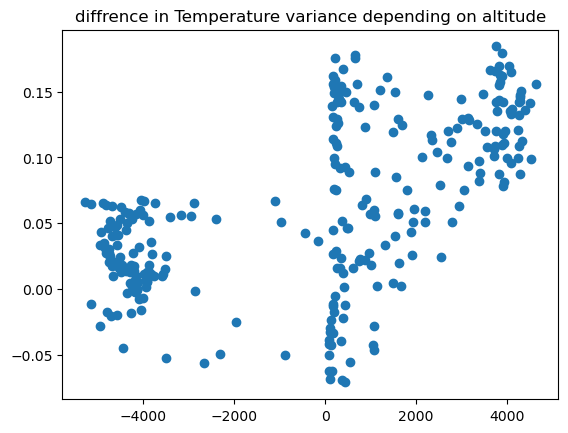

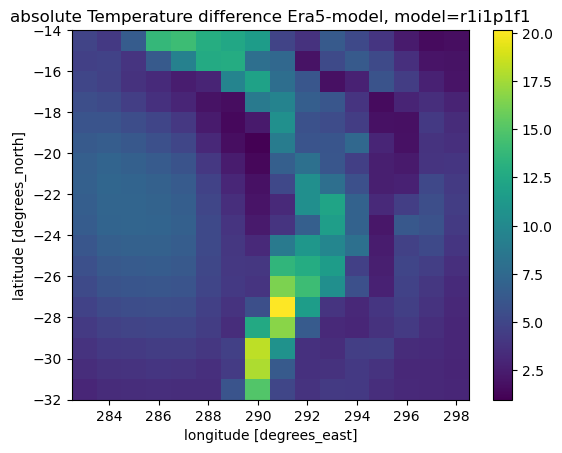

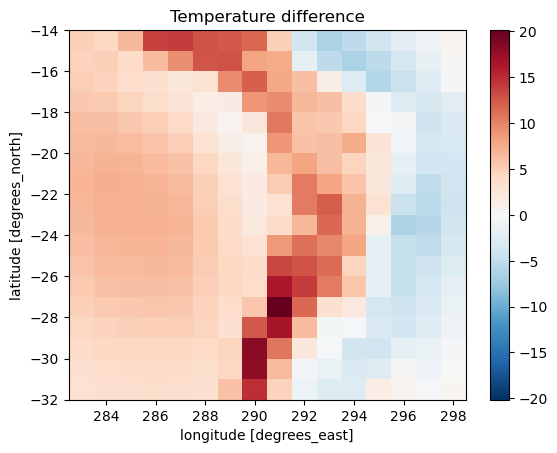

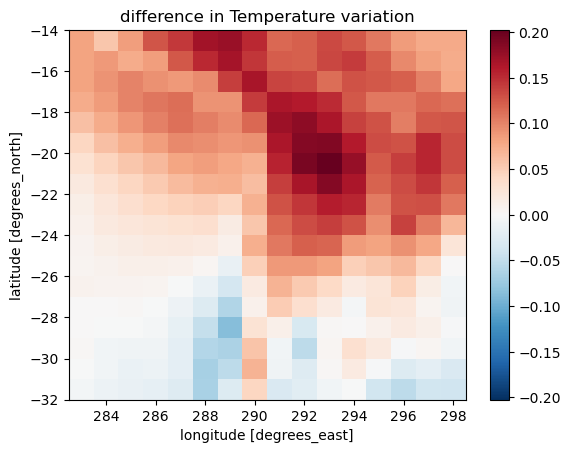

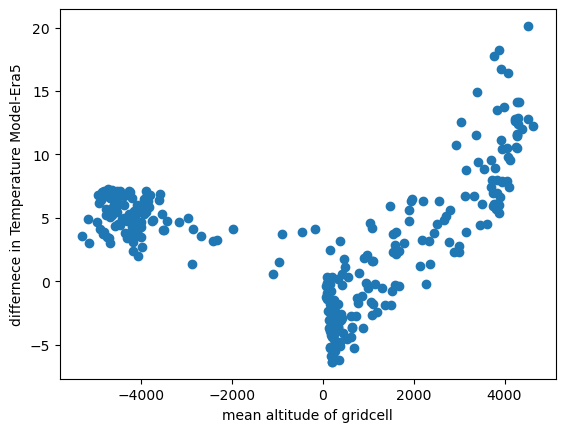

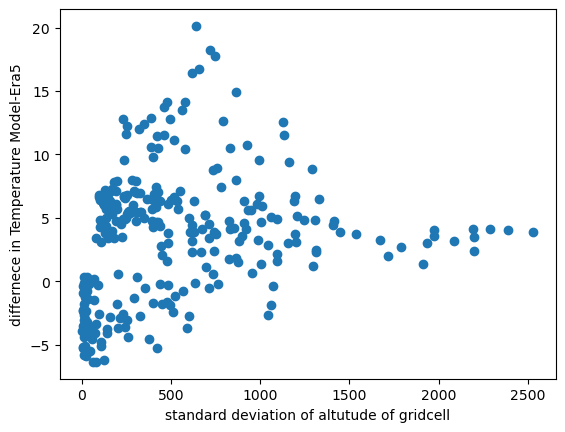

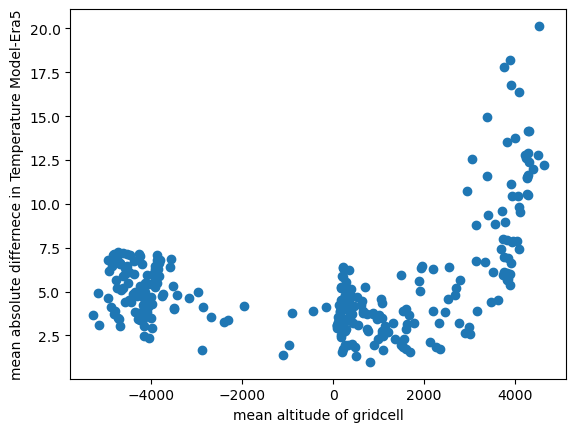

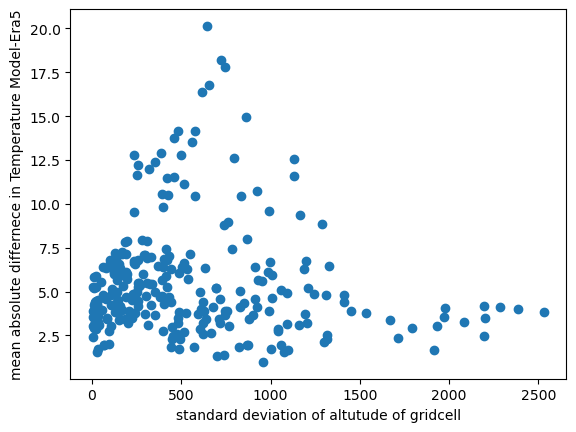

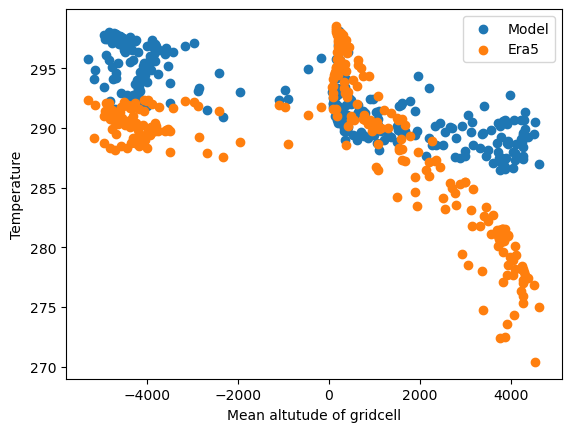

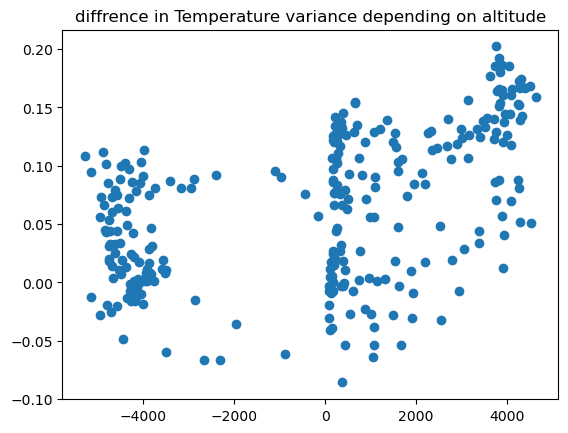

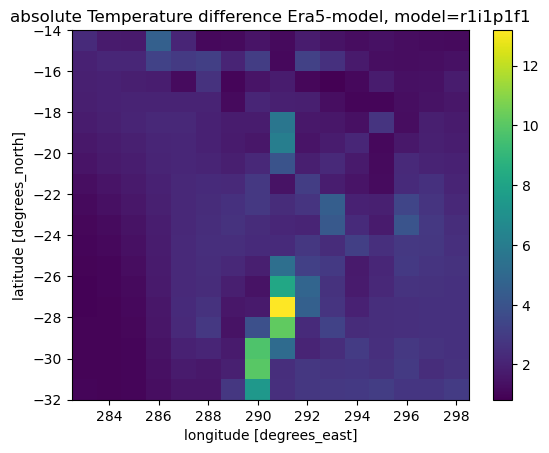

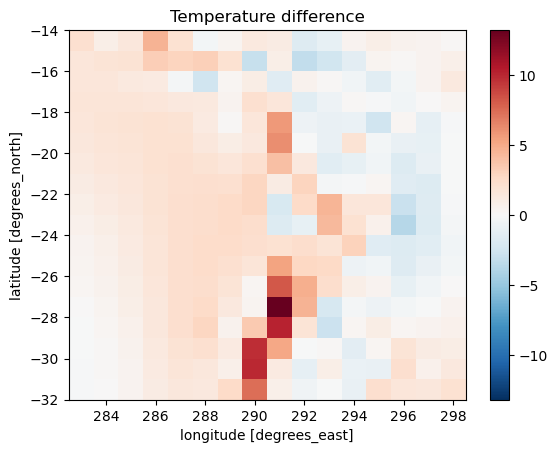

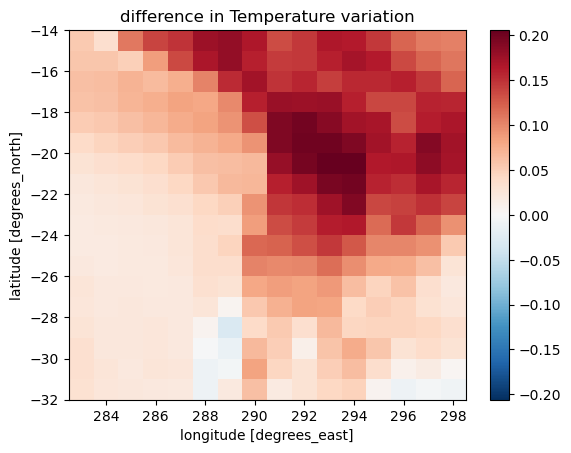

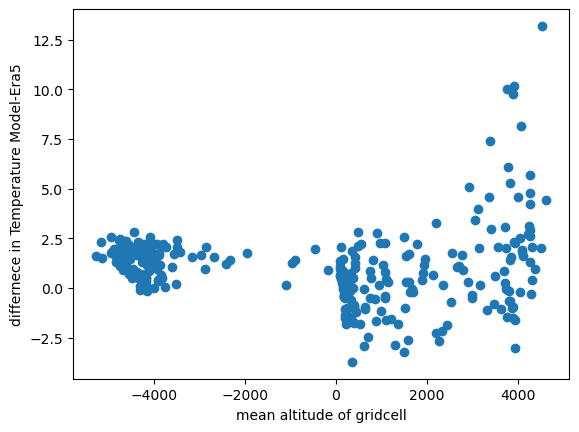

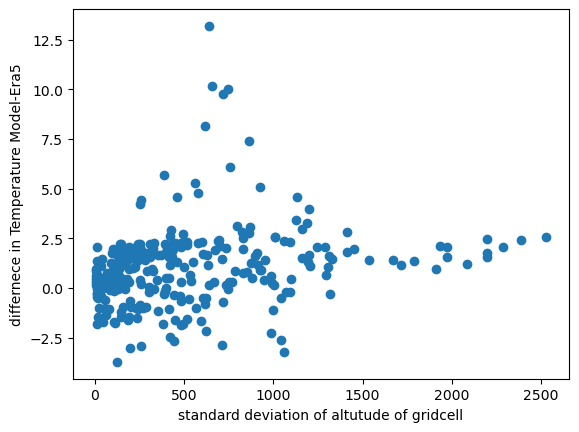

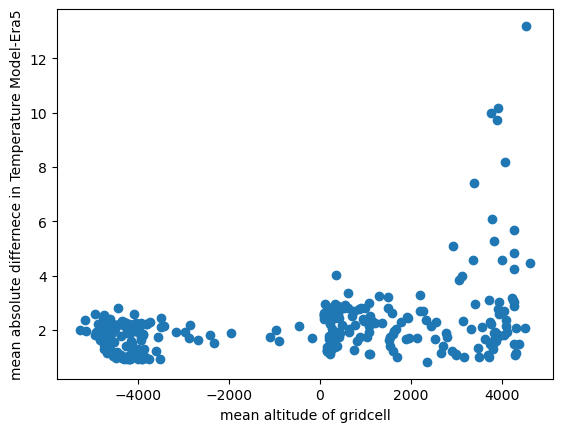

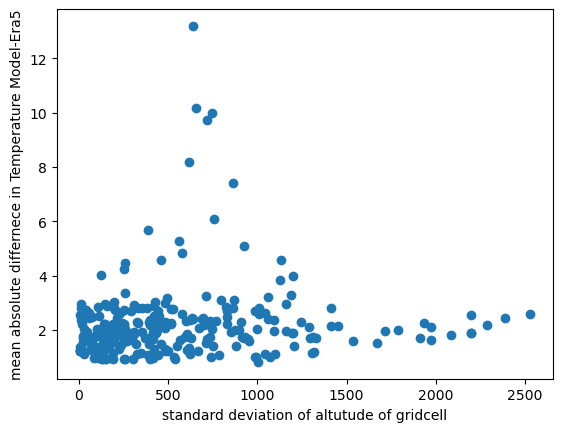

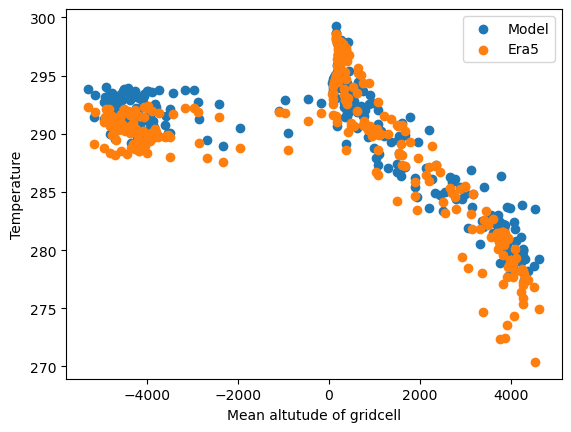

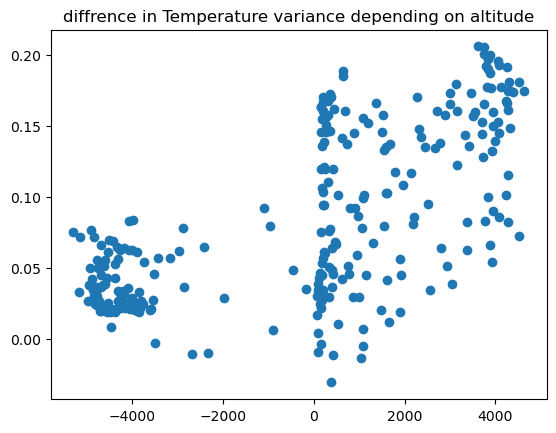

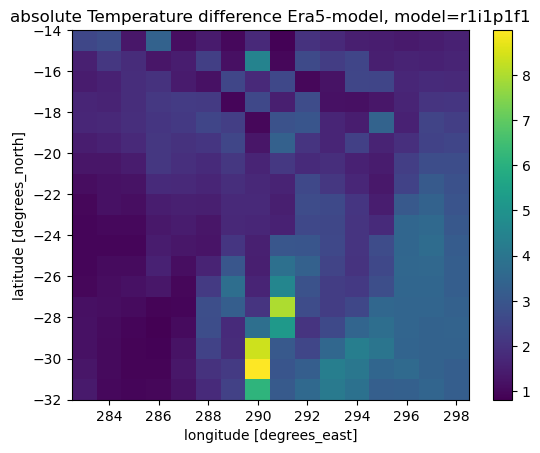

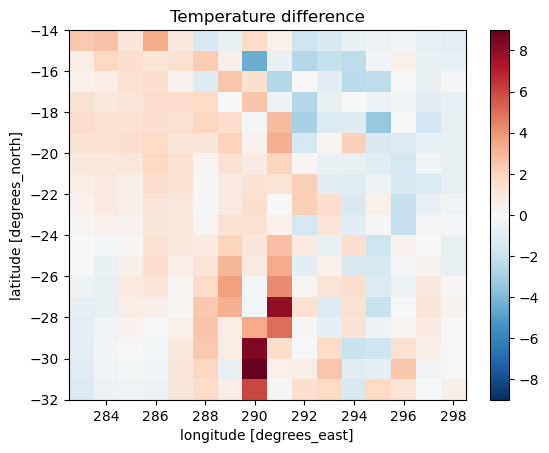

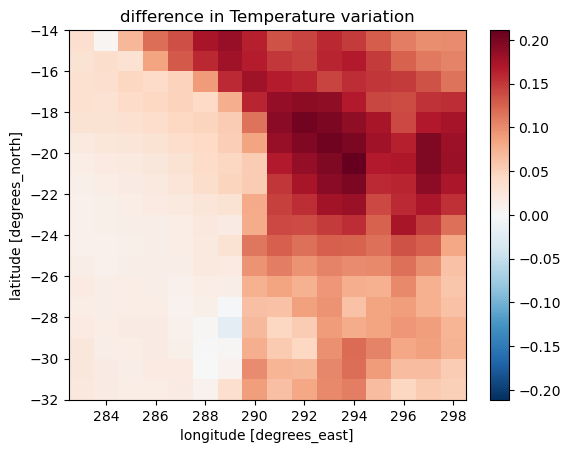

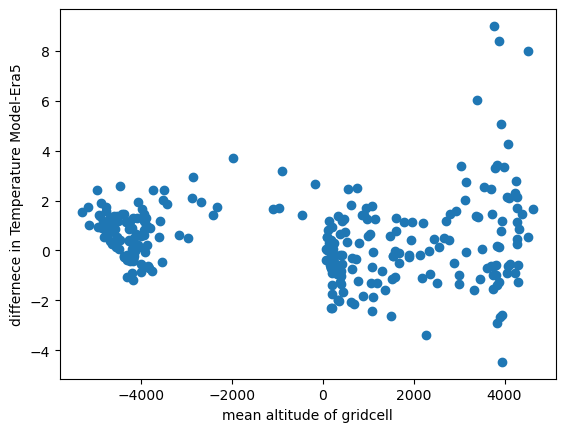

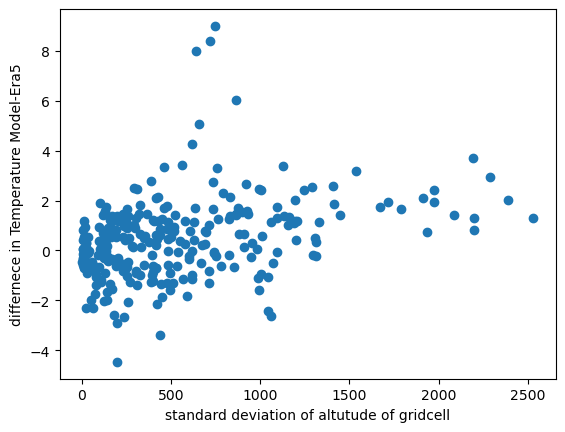

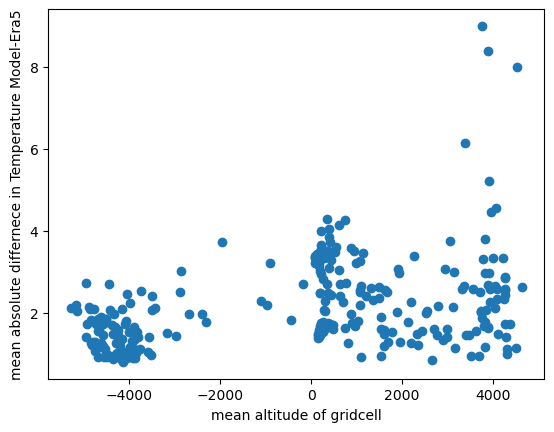

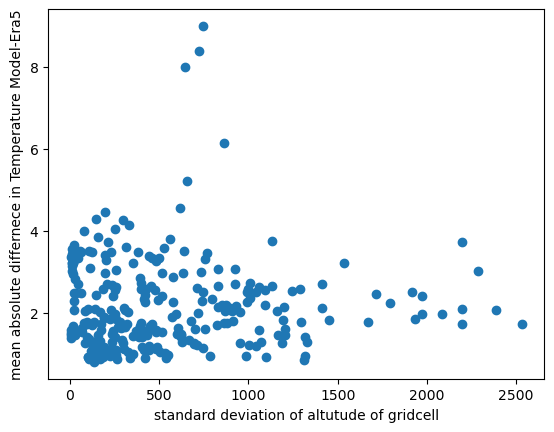

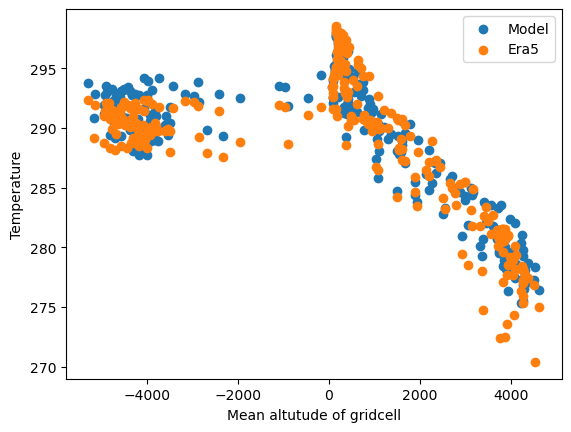

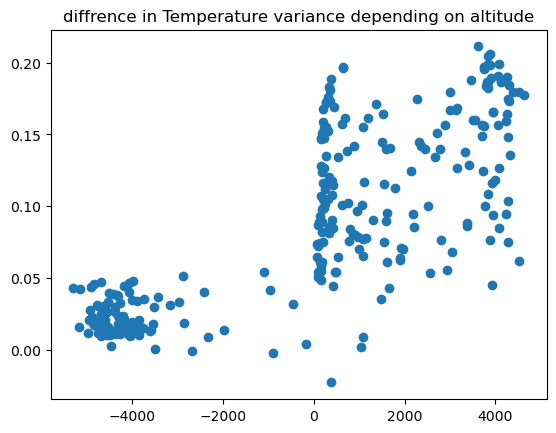

In [14]:
for i in range(5):
    current_model = next(dsiter)
    #current_model = next(dsiter)
    curr_ds = dsets[current_model]
    curr_ds = curr_ds.sortby("time")
    try:
        idkwhattocallthis(curr_ds)
    except:
        pass

In [1]:
a.plot()

NameError: name 'a' is not defined

In [67]:
(a-b).mean("time").values

array([[[[-4.30944502e-01, -2.10546106e-01,  1.64077714e-01,
           7.19486415e-01,  1.27394748e+00,  2.18972468e+00,
           4.68955421e+00,  9.74680138e+00,  1.87051511e+00,
           1.24599181e-01,  1.04861164e+00,  8.05725098e-01,
           3.80611014e+00,  2.57385731e+00,  2.28024411e+00,
           3.01790619e+00],
         [-4.20471162e-01, -1.91116527e-01,  1.97581574e-01,
           8.48532498e-01,  1.50691819e+00,  2.42879176e+00,
           3.08327413e+00,  1.23763437e+01,  2.69272137e+00,
          -2.06379294e-01,  2.17804289e+00,  1.46215618e+00,
           1.45695722e+00,  3.59066844e+00,  1.82772243e+00,
           2.74176025e+00],
         [-4.08266753e-01, -1.71672463e-01,  2.67864048e-01,
           9.70646799e-01,  1.73405635e+00,  2.58394861e+00,
           2.81538320e+00,  1.22043877e+01,  5.64572620e+00,
           3.24569821e-01,  1.30973101e+00,  3.58278155e-01,
           1.05419314e+00,  2.84786725e+00,  2.60817838e+00,
           2.92770362e+00],
 

In [68]:
np.abs(a-b).mean("time").values

array([[[[ 1.0444375 ,  0.98028946,  0.94303536,  1.0980014 ,
           1.4415146 ,  2.2635477 ,  4.7308593 ,  9.746801  ,
           3.0260196 ,  3.257415  ,  3.6460326 ,  3.6506355 ,
           4.326207  ,  3.568004  ,  3.4195373 ,  3.6895816 ],
         [ 1.0496109 ,  0.99305236,  0.95393586,  1.1685611 ,
           1.626596  ,  2.441141  ,  3.2346816 , 12.376344  ,
           3.3543055 ,  3.1023993 ,  3.7011511 ,  3.697612  ,
           3.4964724 ,  4.126124  ,  3.1962245 ,  3.4849236 ],
         [ 1.0561    ,  0.99450284,  0.9761845 ,  1.239227  ,
           1.8242741 ,  2.5986602 ,  2.914143  , 12.204388  ,
           5.675593  ,  2.4072824 ,  3.0888531 ,  3.5639796 ,
           3.4750628 ,  3.8274388 ,  3.6192722 ,  3.6502697 ],
         [ 1.0563473 ,  0.9974028 ,  0.99798113,  1.2796563 ,
           1.9220841 ,  2.7535703 ,  2.036894  ,  7.45414   ,
           9.637791  ,  2.3814769 ,  2.6483061 ,  3.4144752 ,
           3.6331487 ,  3.5664096 ,  3.667057  ,  3.7132308 ],
    

In [12]:
start_date = "1980-01-01"
end_date   = "2005-12-31"
Era5_1deg_red = data_1deg["t2m"].sel({"lat":slice(lat_boundary[0],lat_boundary[1]),"lon":slice(long_boundary[0],long_boundary[1])}).rename({"valid_time":"time"}).sel({"time":slice(start_date,end_date)})
Cmip_data_red = curr_ds["tas"].sel({"lat":slice(lat_boundary[0],lat_boundary[1]),"lon":slice(long_boundary[0],long_boundary[1])}).sel({"time":slice(start_date,end_date)})

Era5_1deg_red_mean = Era5_1deg_red.mean("time")
Cmip_data_red_mean = Cmip_data_red.mean("time")

regrid_cmip_to_era5 = xesmf.Regridder(Cmip_data_red, Era5_1deg_red, method='bilinear', periodic=True)
regrid_cmip_to_era5_mean = xesmf.Regridder(Cmip_data_red_mean, Era5_1deg_red_mean, method='bilinear', periodic=True)

regrid_era5_to_cmip =  xesmf.Regridder(Era5_1deg_red , Cmip_data_red, method='bilinear', periodic=True)
#regrid_cmip_to_era5 = xesmf.Regridder(Cmip_data_red, Era5_1deg_red, method='conservative', periodic=False)


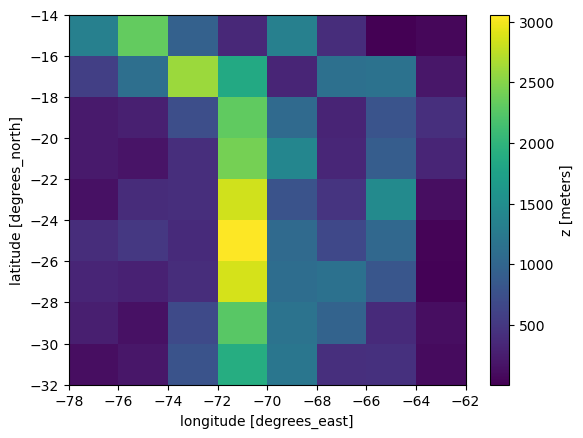

In [45]:
x.std()["z"].plot()

In [25]:
andes = [-32, -14, 360-78+0.5, 360-62+0.5]
boundary = andes
elevation_andes = get_elevation_data(elevation_data,bounds=andes)
x =elevation_andes.coarsen({"lat":60,"lon":60})#,coord_func="mean")
elevation_mean = x.mean()
elevation_std = x.std()

Era5_1deg_red = data_1deg["t2m"].sel({"lat":slice(boundary[0],boundary[1]),"lon":slice(boundary[2],boundary[3])}).rename({"valid_time":"time"})

In [31]:
elevation_andes.coarsen({"lat":60,"lon":60}).mean()

<xarray.Dataset> Size: 1kB
Dimensions:  (lat: 18, lon: 16)
Coordinates:
  * lat      (lat) float64 144B -31.5 -30.5 -29.5 -28.5 ... -16.5 -15.5 -14.5
  * lon      (lon) float64 128B -77.0 -76.0 -75.0 -74.0 ... -64.0 -63.0 -62.0
Data variables:
    crs      |S1 1B b''
    z        (lat, lon) float32 1kB -4.168e+03 -4.248e+03 ... 191.2 212.6
Attributes:
    GDAL_AREA_OR_POINT:             Area
    node_offset:                    1
    GDAL_TIFFTAG_COPYRIGHT:         DOC/NOAA/NESDIS/NCEI > National Centers f...
    GDAL_TIFFTAG_DATETIME:          20220929123913.0
    GDAL_TIFFTAG_IMAGEDESCRIPTION:  Topography-Bathymetry; EGM2008 height
    Conventions:                    CF-1.5
    GDAL:                           GDAL 3.3.2, released 2021/09/01
    NCO:                            netCDF Operators version 4.9.1 (Homepage ...

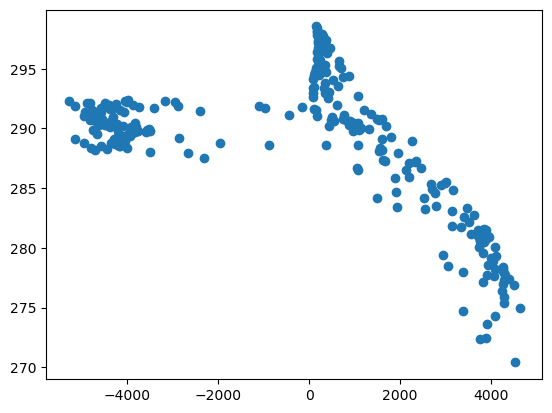

In [22]:
plt.scatter(elevation_mean["z"].values.flatten(),Era5_1deg_red.mean("time").values.flatten())

In [23]:
plt.scatter(elevation_mean["z"].values.flatten(),a.mean("time").values.flatten())

NameError: name 'a' is not defined

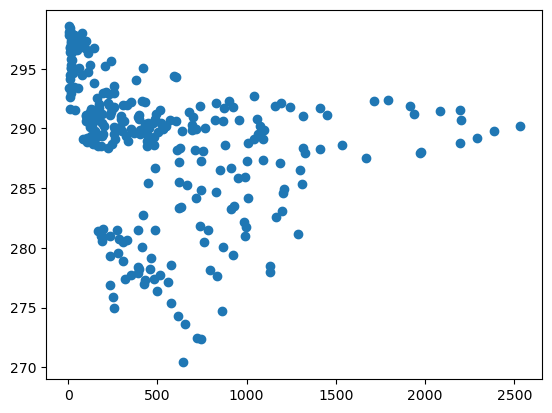

In [24]:
plt.scatter(elevation_std["z"].values.flatten(),Era5_1deg_red.mean("time").values.flatten())

In [89]:
start_date = "1940-01-01"
end_date   = "2026-12-31"
#Cmip_data_red = Cmip_data_red.sel({"time":slice(start_date,end_date)})
tas = regrid_cmip_to_era5(Cmip_data_red)
E5_regrid = regrid_era5_to_cmip(Era5_1deg_red)
tas_mean = regrid_cmip_to_era5(Cmip_data_red_mean)

In [91]:
b = Era5_1deg_red.resample(time="1ME").nearest()
a = tas.resample(time="1ME").nearest()
a["time"] = a.time.astype("datetime64[ns]")

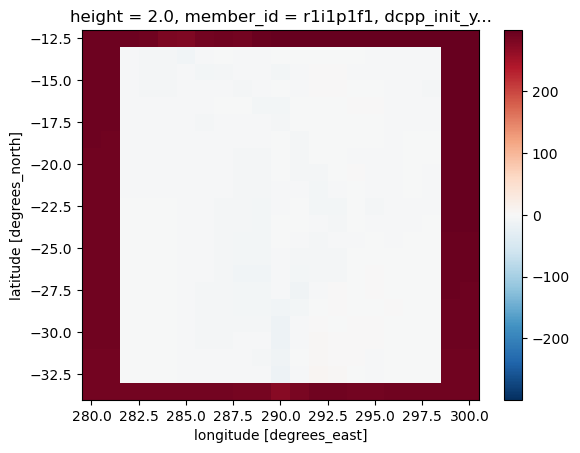

In [28]:
(Era5_1deg_red_mean-tas_mean).plot()

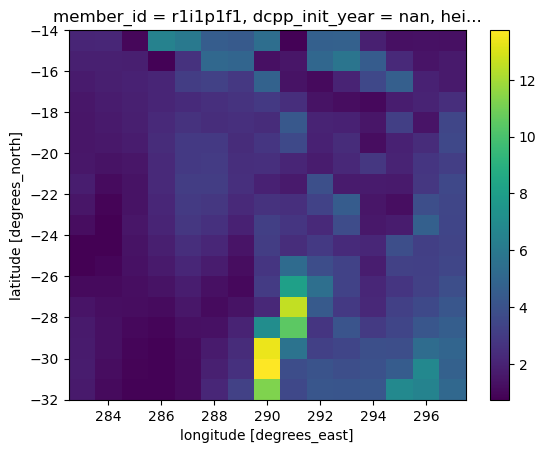

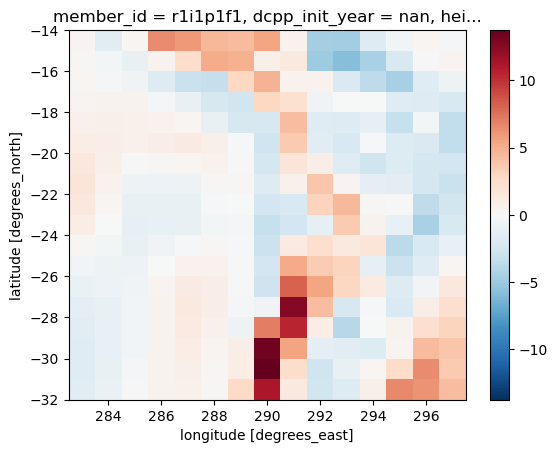

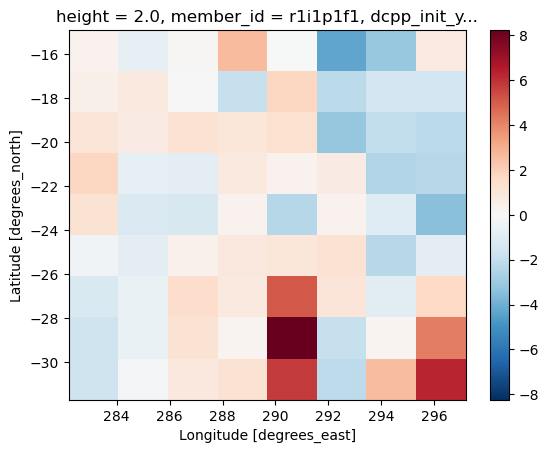

In [ ]:
cutoff = 2.1
lat_boundary_adj = [lat_boundary[0]+cutoff,lat_boundary[1]-cutoff]#[-32,-14]
long_boundary_adj =  [long_boundary[0]+cutoff,long_boundary[1]-cutoff]#[360-78,360-62]
atts1deg = ["t2m","lat","lon"]

#lat_vals_1deg,long_vals_1deg = lat_lon_sel(data_1deg,lat_boundary_adj,long_boundary_adj,atts1deg)

a = a.sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])})
b = b.sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])})
(abs(a-b)).mean("time").plot()
plt.figure()
((a-b)).mean("time").plot()



#CMIP scale:
#plt.figure()
#(Cmip_data_red.mean("time")-E5_regrid.mean("time")).sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])}).plot()

Text(0.5, 0, 'standard deviation of lattitude of gridcell')

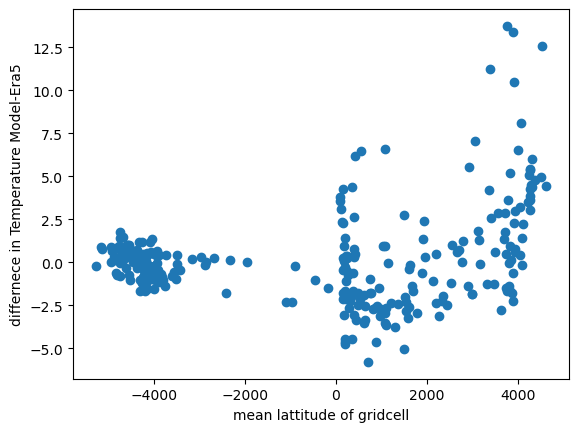

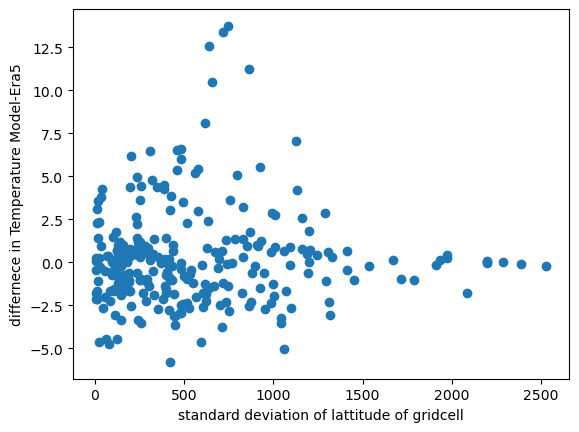

In [101]:
plt.scatter(elevation_mean.sel({"lon":slice(-77,-63)})["z"].values,(a-b).mean("time").values)
plt.ylabel("differnece in Temperature Model-Era5")
plt.xlabel("mean lattitude of gridcell")
plt.figure()
plt.scatter(elevation_std.sel({"lon":slice(-77,-63)})["z"].values,(a-b).mean("time").values)
plt.ylabel("differnece in Temperature Model-Era5")
plt.xlabel("standard deviation of lattitude of gridcell")

In [ ]:
(a-b).mean("time")

<xarray.DataArray (member_id: 1, dcpp_init_year: 1, lat: 18, lon: 15)> Size: 1kB
dask.array<mean_agg-aggregate, shape=(1, 1, 18, 15), dtype=float32, chunksize=(1, 1, 18, 15), chunktype=numpy.ndarray>
Coordinates:
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
  * lon             (lon) float64 120B 283.0 284.0 285.0 ... 295.0 296.0 297.0
  * lat             (lat) float64 144B -31.5 -30.5 -29.5 ... -16.5 -15.5 -14.5
    height          float64 8B ...

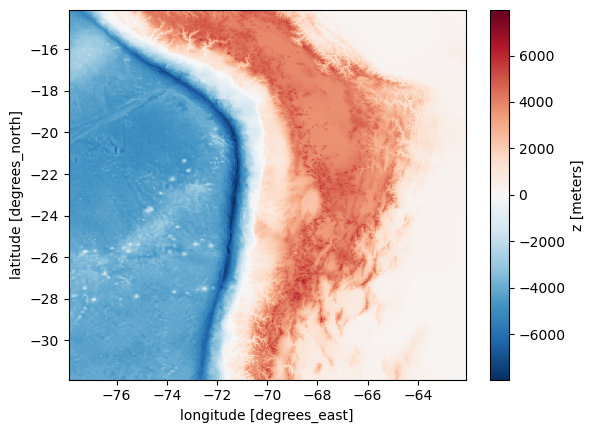

In [16]:
elevation_data["z"].sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0]-360,long_boundary_adj[1]-360)}).plot()

/opt/conda/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')
/opt/conda/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')
/opt/conda/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/opt/conda/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')
/opt/conda/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')
/opt/conda/lib/python3.10/sit

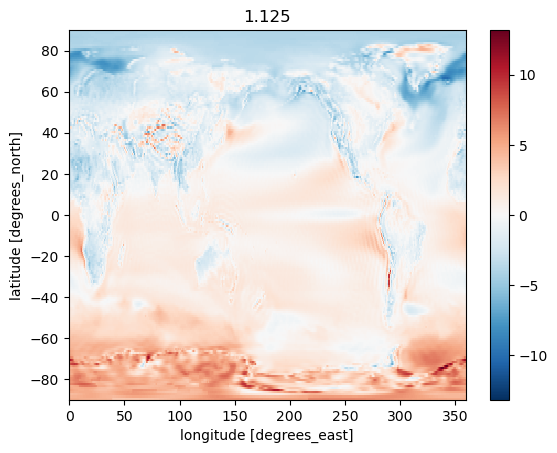

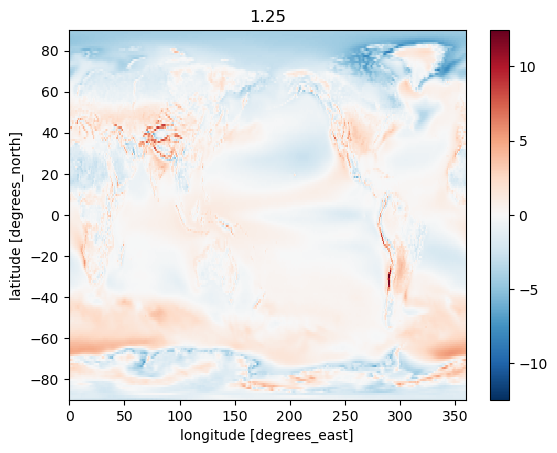

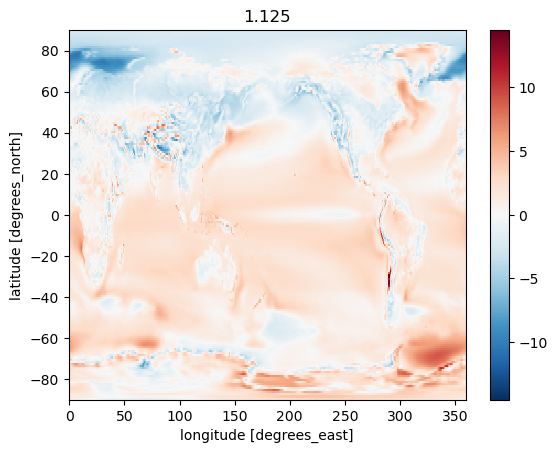

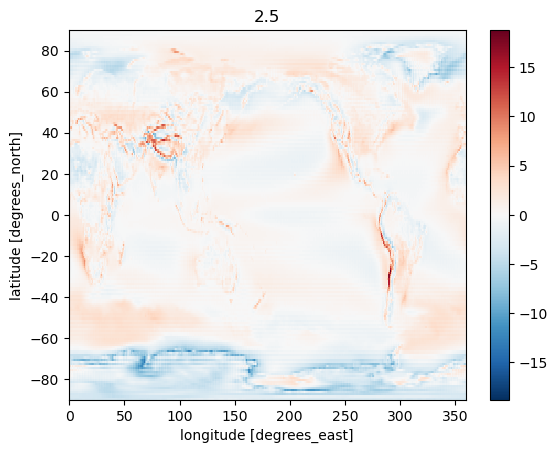

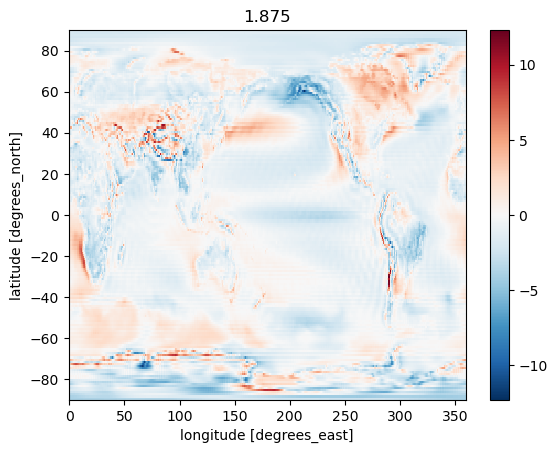

In [35]:

lat_boundary = [-93,93]#[-40,-10]#[-32,-14]
long_boundary =[-3,363]#[360-85,360-55] #[360-78,360-62]

dsiter = iter(dsets)
n = 5
start_date = "1980-01-01"
end_date   = "2005-12-31"
Era5_1deg_red = data_1deg["t2m"].sel({"lat":slice(lat_boundary[0],lat_boundary[1]),"lon":slice(long_boundary[0],long_boundary[1])}).rename({"valid_time":"time"}).sel({"time":slice(start_date,end_date)})
b = Era5_1deg_red.resample(time="1ME").nearest()
for i in range(n):#36
    current_model = next(dsiter)
    curr_ds = dsets[current_model]
    curr_ds = curr_ds.sortby("time")

    
    #datasets use different variable names for their spacial data we want to average over
    if "lat" in dsets[current_model].coords:
        #CMIP_mean_temps = curr_ds["tas"].mean(dim=['lat', 'lon']).resample(time="YE").mean().values.ravel()
        

        Cmip_data_red = curr_ds["tas"].sel({"lat":slice(lat_boundary[0],lat_boundary[1]),"lon":slice(long_boundary[0],long_boundary[1]),"time":slice(start_date,end_date)})

        regrid_cmip_to_era5 = xesmf.Regridder(Cmip_data_red, Era5_1deg_red, method='conservative_normed', periodic=True)
        tas = regrid_cmip_to_era5(Cmip_data_red)
        E5_1deg_month = Era5_1deg_red.resample(time="1ME").nearest()
        cmip5_month = tas.resample(time="1ME").nearest()
        cmip5_month["time"] = cmip5_month.time.astype("datetime64[ns]")

        cutoff = Cmip_data_red.lon.values[1]-Cmip_data_red.lon.values[0]
        lat_boundary_adj = [lat_boundary[0],lat_boundary[1]]#-cutoff]#[-32,-14]
        long_boundary_adj =  [long_boundary[0],long_boundary[1]]#-cutoff]#[360-78,360-62]
        atts1deg = ["t2m","lat","lon"]

        #lat_vals_1deg,long_vals_1deg = lat_lon_sel(data_1deg,lat_boundary_adj,long_boundary_adj,atts1deg)

        cmip5_month = cmip5_month.sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])})
        E5_1deg_month = E5_1deg_month.sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])})
        plt.figure()
        (cmip5_month-E5_1deg_month).mean("time").plot()
        plt.title(str(cutoff))
        #plt.figure()
        #(cmip5_month.mean("time")-E5_1deg_month.mean("time")).plot()
    elif "i" in dsets[current_model].coords:
        continue
        #CMIP_mean_temps = curr_ds["tas"].mean("i").resample(time="YE").mean().values.ravel()
    else:
        continue
        #CMIP_mean_temps = curr_ds["tas"].mean(dim=['latitude', 'longitude']).resample(time="YE").mean().values.ravel()


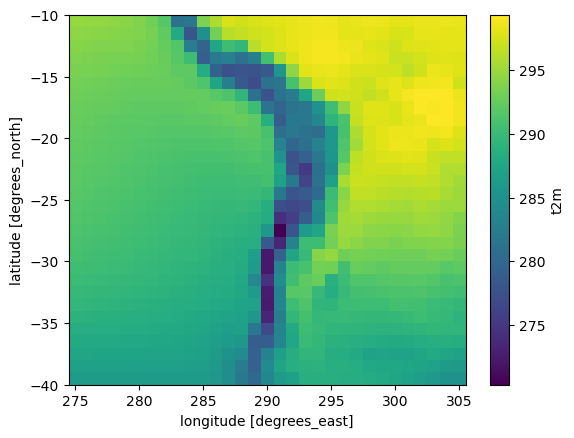

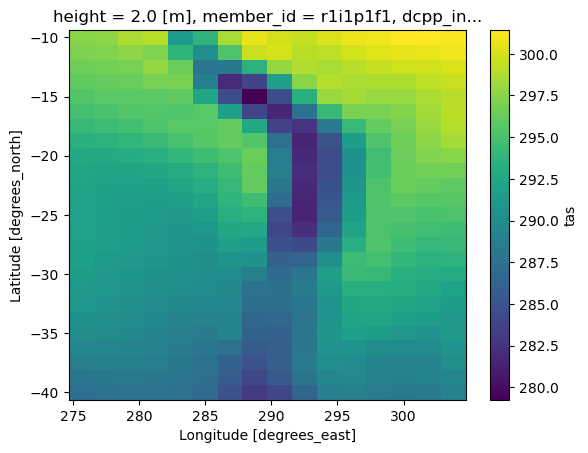

In [31]:

lat_boundary = [-40,-10]#[-32,-14]
long_boundary =[360-85,360-55] #[360-78,360-62]
"""
lat_boundary = [-90,90]#[-32,-14]
long_boundary =[0,360]
"""
Era5_1deg_red = data_1deg["t2m"].sel({"lat":slice(lat_boundary[0],lat_boundary[1]),"lon":slice(long_boundary[0],long_boundary[1])}).rename({"valid_time":"time"}).sel({"time":slice(start_date,end_date)})
dsiter = iter(dsets)
curr_ds = dsets[current_model]
curr_ds = curr_ds.sortby("time")
Cmip_data_red = curr_ds["tas"].sel({"lat":slice(lat_boundary[0],lat_boundary[1]),"lon":slice(long_boundary[0],long_boundary[1]),"time":slice(start_date,end_date)})
b = Era5_1deg_red
a = Cmip_data_red
b.mean("time").plot()
plt.figure()
a.mean("time").plot()

In [ ]:
cat_subset.to_datatree()

In [44]:
tree_gm = cat_subset.to_datatree().map_over_subtree(global_mean)

ImportError: .to_datatree() requires the xarray-datatree package to be installed. To proceed please install xarray-datatree using:  `python -m pip install xarray-datatree` or `conda install -c conda-forge xarray-datatree`.

In [39]:
def global_mean(ds):
    try:
        _weights = np.cos(np.deg2rad(ds["lat"]))
        _weights.name = "weights"
        return ds.weighted(_weights).mean(["lat","lon"]).compute().squeeze()
    except:
        print("Global mean as implemented for lat-lon grid does not work:", ds.attrs["institution_id"], ds.attrs["source_id"])

In [ ]:
b = Era5_1deg_red.resample(time="1ME").nearest()
a = tas.resample(time="1ME").nearest()

In [157]:
start_date = "1940-01-01"
end_date   = "2026-12-31"
Cmip_data_red = Cmip_data_red.sel({"time":slice(start_date,end_date)})

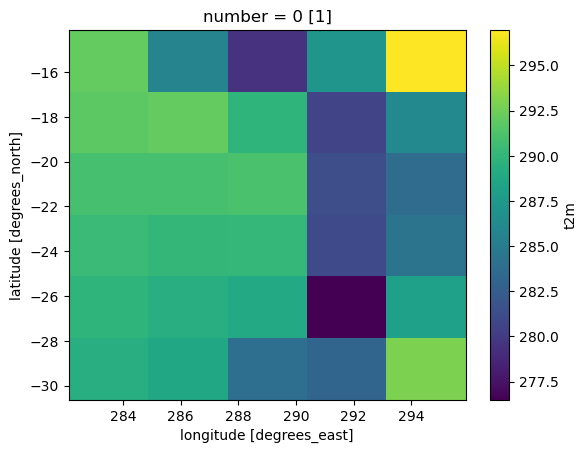

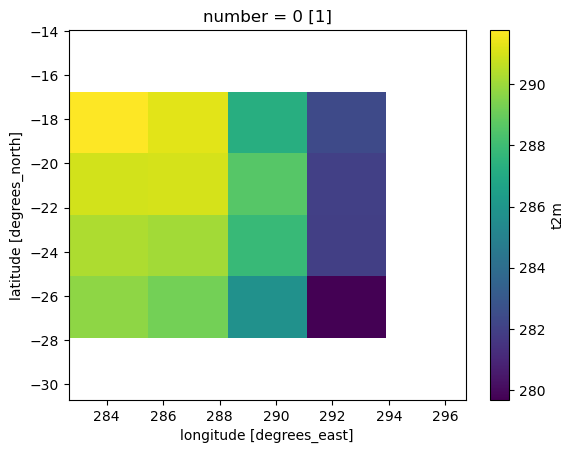

In [106]:
factor=11
Era5_coarse = Era5.coarsen(latitude=factor,longitude=factor,boundary="trim").mean()
Era5_int = Era5_coarse.interp(latitude=d_lat_vals,longitude=d_long_vals,method="linear")
Era5_coarse.plot()
plt.figure()
Era5_int.plot()

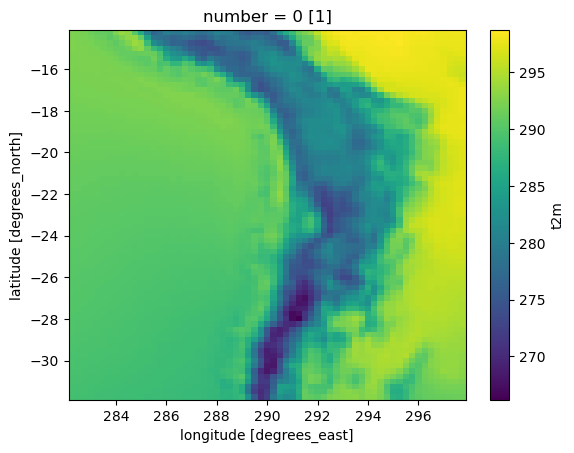

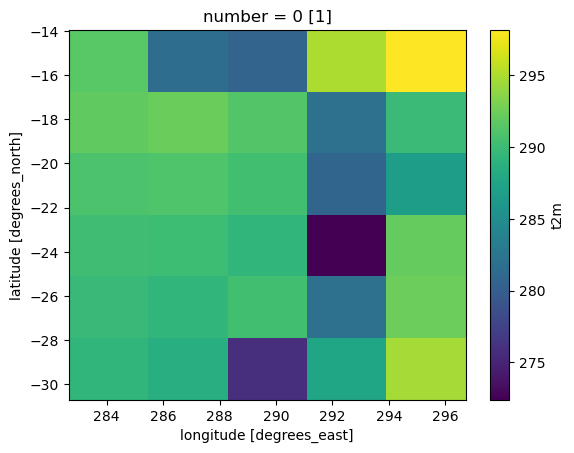

In [69]:
#plt.subplots(1,2)
Era5.plot()
plt.figure()
Era5.interp(latitude=d_lat_vals,longitude=d_long_vals,method="linear").plot()


In [57]:
dsiter = iter(dsets)

n = 36
lattice = []
for i in range(n):#36
    current_model = next(dsiter)
    curr_ds = dsets[current_model]
    try:
        d_lat_vals = curr_ds["tas"]["lat"].values
        lattice.append((d_lat_vals[1]-d_lat_vals[0]))
    except:
        pass

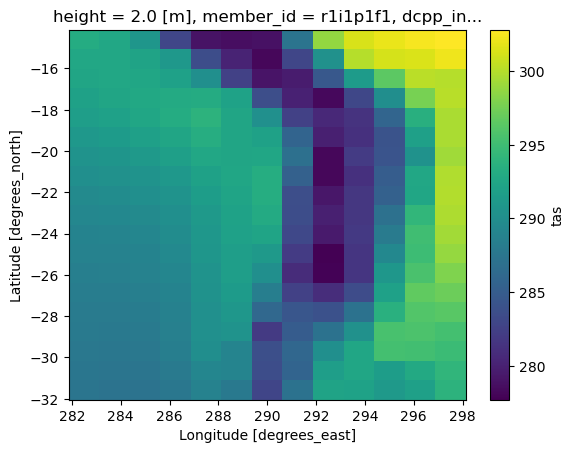

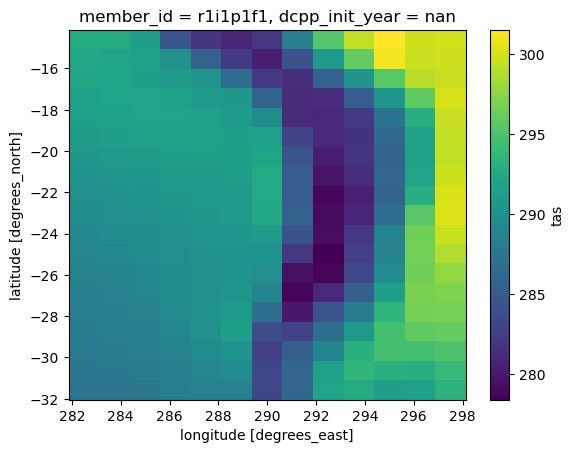

In [ ]:
lat_boundary = [-32,-14]
long_boundary = [360-78,360-62]




dsiter = iter(dsets)

n = 2
times_mean = np.arange(1850,2024,1)         #timesstamps for model mean
model_mean = np.zeros(times_mean.size)      #variable for the mean of the model
model_mean_diff = np.zeros(times_mean.size) #variable for mean anomaly
meancount = np.zeros(times_mean.size)       #count of how many models contribute to the mean(at borders only like 2 models contribute so we cannot divide by n)
maxsize = 0
model_temps = []
for i in range(n):#36
    current_model = next(dsiter)
    curr_ds = dsets[current_model]
    curr_ds = curr_ds.sortby("time")

    #datasets use different variable names for their spacial data we want to average over
    if "lat" in dsets[current_model].coords:
        #CMIP_mean_temps = curr_ds["tas"].mean(dim=['lat', 'lon']).resample(time="YE").mean().values.ravel()
        
        d_lat_vals = curr_ds["tas"]["lat"].values
        d_long_vals = curr_ds["tas"]["lon"].values
        d_lat_vals = d_lat_vals[d_lat_vals>lat_boundary[0]]
        d_lat_vals = d_lat_vals[d_lat_vals<lat_boundary[1]]

        d_long_vals = d_long_vals[d_long_vals>long_boundary[0]]
        d_long_vals = d_long_vals[d_long_vals<long_boundary[1]]
        plt.figure()
        curr_ds["tas"].sel({"lat":d_lat_vals,"lon":d_long_vals}).mean("time").plot()

    elif "i" in dsets[current_model].coords:
        continue
        #CMIP_mean_temps = curr_ds["tas"].mean("i").resample(time="YE").mean().values.ravel()
    else:
        continue
        #CMIP_mean_temps = curr_ds["tas"].mean(dim=['latitude', 'longitude']).resample(time="YE").mean().values.ravel()
    """
    m1850_1900 = CMIP_mean_temps[:50].mean()

    times = curr_ds.resample(time="YE").mean()["time"].values.astype('datetime64[Y]')
    label = str.join("-",current_model.split(".")[1:3])

    #calculate the effect on mean of models
    if CMIP_mean_temps.size>maxsize:
        maxsize=CMIP_mean_temps.size
        mtimes=times
    meancount[:CMIP_mean_temps.size]+=1
    model_mean[:CMIP_mean_temps.size] +=+CMIP_mean_temps
    model_mean_diff[:CMIP_mean_temps.size] +=+CMIP_mean_temps-m1850_1900

    model_temps.append([times,CMIP_mean_temps,m1850_1900,label])

times_mean = times_mean[:maxsize]
model_mean = model_mean[:maxsize]/meancount[:maxsize]
model_mean_diff = model_mean_diff[:maxsize]/meancount[:maxsize]
mmm1850_1900 = model_mean[:50].mean()
"""